# Binary Classifier w/ Embedding


This Notebook builds on from the previous example. It will show how to include an embedding layer.

---
Embeddings are an importan concept in modern deep learning. Especially for tabular data and NLP style applications. They are basically high dimensional spaces in which the model tries to position the elements so their distance is useful for the problem at hand.

That sound very abstract. But it turns out that the by asking the model to position the elements of a field in this space, some of the axis in this space convey a 'meaning' an aspect of the elements. 

There's a lot of good examples out there. One simple and interesting example is an NLP one where a model is asked to predict the words around a given word. If one plots countries and capitals of that embedding and reduces along a certain set of axis one get a picture like below where the countries are on one side, and the capitals on another side. Moreover there is a very similar vector going from country to capital. This vector can be thought of as a __transformation__ from capital to country. The model has learnt this relationship and can use it to solve problems.

Obviously for real life problems these spaces can have hundreds of dimensions, giving the model the ability to capture an almost infinate number of 'aspects'. 

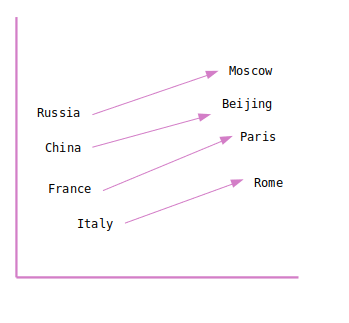

#### Note on the data set 
The data set used here is not particulary complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Base and derived features.
> In order to get the model to use embeddings we will define features of type `FeatureIndex` rather than `FeatureOneHot` (from the previous example). Index features will 'index' a string or categorical variable. They will for instance turn [FR, FR, GB, DE, GB] into [1, 1, 2, 3, 2]. Where each country now has its own unique number.

> Note how in the output we see has less columns. The values for the index are no longer binary 0 and 1 like for the one-hot features.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
# Define Index Features. This part is different from the previous example
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
# End of difference
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_scale,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(learning_features, df, inference=False)

df

2020-11-06 14:13:23.907 d373c7.engines.common          INFO     Start Engine...
2020-11-06 14:13:23.908 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-06 14:13:23.908 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-06 14:13:23.908 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-11-06 14:13:24.114 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-11-06 14:13:24.120 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)
2020-11-06 14:13:24.120 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-11-06 14:13:24.149 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2020-11-06 14:13:24.163 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 6)


,age_index,gender_index,merchant_index,category_index,amount_scale,fraud_label
0,1,1,1,1,0.000546,0
1,2,1,1,1,0.004764,0
2,1,2,2,1,0.003228,0
3,3,1,1,1,0.002071,0
4,4,1,1,1,0.004288,0
...,...,...,...,...,...,...
594638,3,2,2,1,0.002465,0
594639,1,2,2,1,0.006090,0
594640,2,2,15,11,0.002694,0
594641,4,1,2,1,0.001736,0


## Convert to Numpy
After converting the panda DataFrame to numpy lists per learning type, we have a first list with 1 continous feature (the amount), a second with 4 categorical features (the `FeatureIndex` features) and the last list contain the label

In [6]:
with en.EnginePandasNumpy() as e:
    data_list = e.to_numpy_list(learning_features, df)
print(data_list.shapes)
print(data_list.dtype_names)

2020-11-06 14:15:35.421 d373c7.engines.common          INFO     Start Engine...
2020-11-06 14:15:35.422 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-06 14:15:35.422 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-06 14:15:35.422 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2020-11-06 14:15:35.423 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2020-11-06 14:15:35.424 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int16
2020-11-06 14:15:35.425 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2020-11-06 14:15:35.427 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-11-06 14:15:35.427 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643,), (594643, 4), (594643,)]
['float32', 'int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a training-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.


In [7]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(464643,), (464643, 4), (464643,)]
Validation Data shapes [(30000,), (30000, 4), (30000,)]
Test Data shapes [(100000,), (100000, 4), (100000,)]
Done


## Setup the Devices

In [8]:
device, cpu = pt.init_devices()

2020-11-06 14:16:15.581 d373c7.pytorch.common          INFO     Torch Version : 1.6.0
2020-11-06 14:16:15.648 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-11-06 14:16:15.648 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


# Define Model


The training data set has to be balanced for Neural Nets. To do this, the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label. This may not be a good idea for a really large data sets.

> 1. First set-up a NumpyListDataSet for both the training data-set and validation data-set. A NumpyListDataSet is a specialised `Pytorch Dataset` which keeps the data as numpy arrays in memory and converts on the fly to `Pytorch Tensors`
> 2. Set-up a sampler for the training set only. The sampler will over sample the '1'/fraud class. Note that this means the training and validation set are balanced *differently*. This is important when interpreting the plots.
> 3. Wrap the dataset in a Pytorch Dataloader. `Dataloaders` allow the training loop to iterate over `Datasets`
> 4. Create a model. Here the most basic __FeedforwardFraudClassifier__ is used. A __FeedforwardFraudClassifier__ takes a TensorDefinition as input, runs it through a series of Linear layers, it uses Binary Crossentropy loss. *We are defining it to have 1 hidden layer of size 16*.


Note that even though we defined the model the same way, it's a different model now. The first layer no longer a linear layer. The first layer now has embeddings. One for each index feature

In [9]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)
train_sampler = pt.ClassSampler(learning_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.FeedForwardFraudClassifier(learning_features, [16])
print(m)

FeedForwardFraudClassifier(
  Number of parameters : 2164
  (head): TensorDefinitionHead(
    lcs=['Continuous', 'Categorical']
    (embedding): Embedding(
      (embeddings): ModuleList(
        (0): Embedding(9, 4)
        (1): Embedding(5, 4)
        (2): Embedding(51, 25)
        (3): Embedding(16, 7)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linear(in_features=41, out_features=16, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU(inplace=True)
    )
  )
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): SingleClassBinaryOutput(
    (out_block): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)


#### Graphically the embedding model looks more or less like below.
> Each of the 4 __categorical__ features is feed through an embedding. The embeddings have different dimensions depending on the cardinality of the feature. As output each embedding gives the coordinates of the value in the space. 

> Those coordinates are all concatenated into one big layer and the continuous features is also added on. From there on out the model is similar to the previous FeedForward. The 41 features are fed to a Linear Linear layer with 16 output features and then further to 1 output feature

_*(Some layers have been omitted for simplicity)_

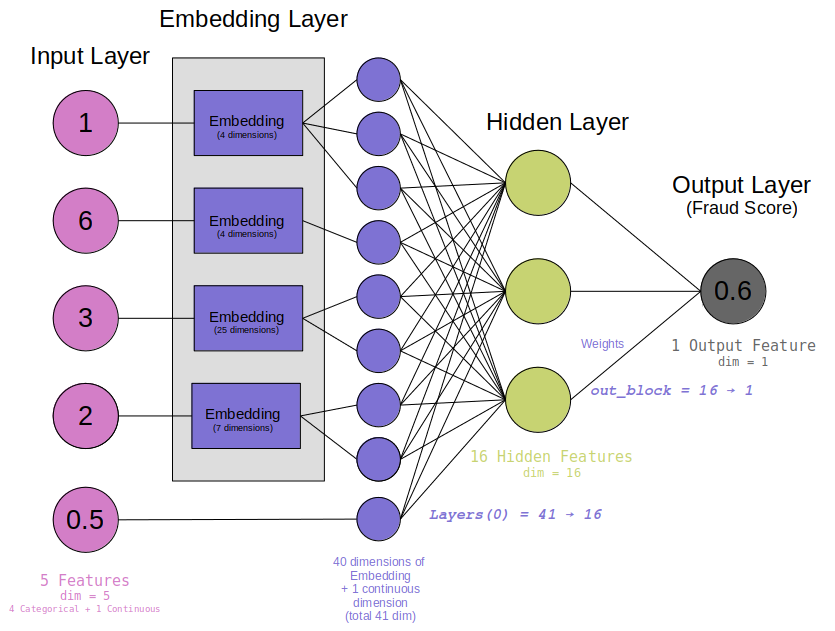

# Start training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr funtion and plot. This iterates over the batched from a minimum to a maximum learning rate. It tends to show where we can find a good learning rate. In this case at around 10e-2 we get a very steep decent. The model does not learn at lower than 10e-4. Beyond 10e-2 it flattens out and explodes later. This can be validate by running with a higher number of iteration and higher upper bound. A good learning rate is a location where the curve starts descending. In this case around __5e-3__

2020-11-06 14:16:56.684 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 324.91it/s]
2020-11-06 14:16:58.865 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


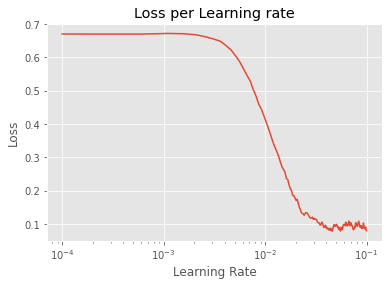

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate. 

Epoch 010/010: 100%|██████████| 3866/3866 [00:08<00:00, 430.65it/s, train_loss=0.0587, train_acc=0.976, val_loss=0.0395, val_acc=0.981]


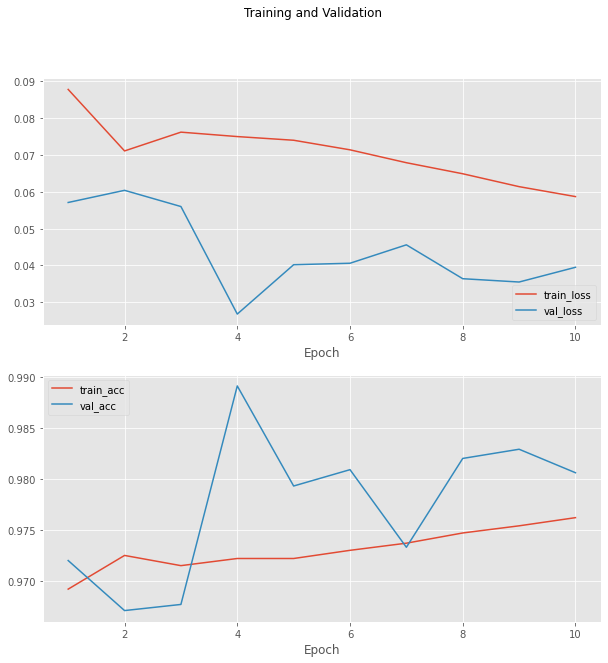

In [11]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-2)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set. This model behaves fairly OK and as we expected. Similar results to the training results, this behaves similar to the previous example 

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 733.80it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.39      0.98      0.56      1074

    accuracy                           0.98    100000
   macro avg       0.69      0.98      0.77    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9987
ap score  : 0.9242
-----------------------------------------------------


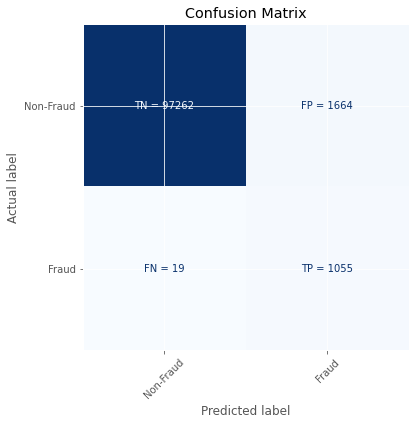

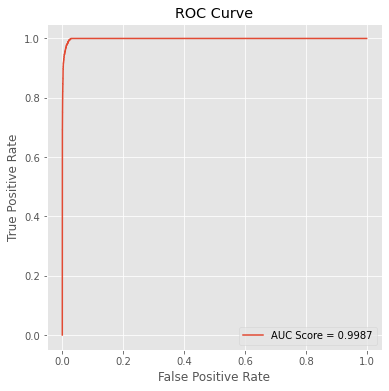

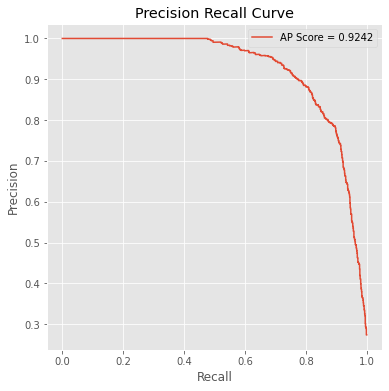

In [11]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> Now that we have a trained model we can plot the embeddings. Embeddings try to capture 'aspects' of the data along certain axis. It does that basically by finding axis in the data along which the most variance occurs.

### Embedding shape
The shape of the trained embedding for the `FeatureIndex` named __'category'__ is 16,7. 
- 16 is the number of different values we have in the category. It is the cardinality of that field (+1 for unknown).
- 7 is the dimensionality of the space

So the embedding is a list of 16 points each in a 7-dimensional space.

In [12]:
w = m.embedding_weights(category_i, True)
print(f'The Shape of w is {w.shape}')

The Shape of w is (16, 7)


### Plotting
The dimensions of this 7-dimensional space can be reduced (using PCA) and plotted in 2 and 3 dimensions. These dimensions are the 'properties' of the data. We can see that an enourmous amount of variance is explained by a the first dimension. This is the axis along which the space streched most, where the model found it has to make the biggest distinction between categories.

In the plots the axis scale is different. The scale of the X axis is much bigger than the Y and Z axis

> Understanding which aspesct/property the embedding are capturing is not easy. The model does not say/know what they are. They might be showing the likelyhood of fraud, the average spend per category, how they are used by age-groups. This is the better guess work, we really only know the model saw fit to use this and found it useful in the classification fraud vs. non-fraud

*The fact the es_leisure is so far from the rest of the points is data related. A totally disproportionately high % of the es_leisure transactions are Fraud. Probably an error in the data*

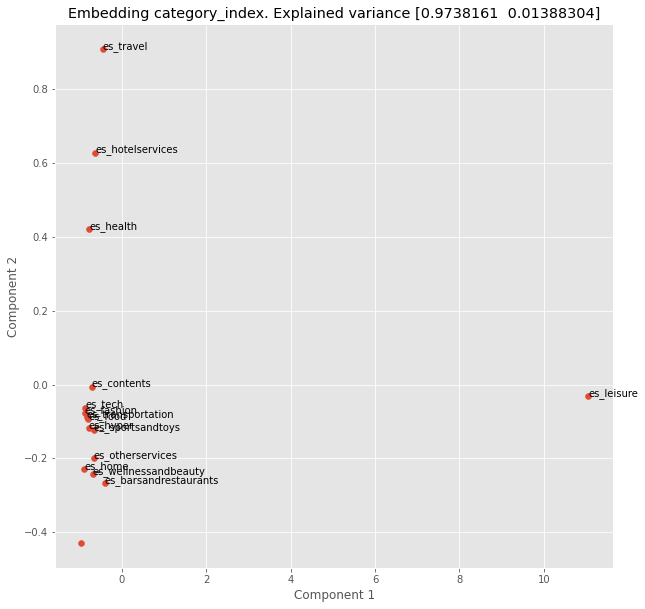

In [12]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, fig_size=(10,10))

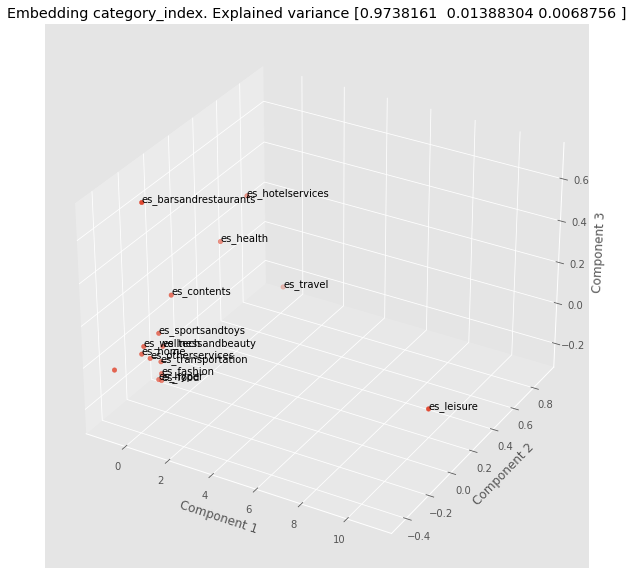

In [13]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
This notebook showed how embeddings can be used. One might wonder what their use is if they do not get us better results. That is mainly due to the file. On bigger more complex dataset in general it is best to set-up categorical fields as embeddings. Competitions like the Kaggle Grossman show that this can come very close to models with 'handcrafted' features
